In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import simpy
import statistics

# Langkah 1 Preprocessing Data

In [176]:
df = pd.read_csv("Telecom-Company-Call-Center-Dataset.csv")
print(df.head())

  Call Id    Agent        Date      Time              Topic Answered (Y/N)  \
0  ID0001    Diane  2021-01-01   9:12:58   Contract related              Y   
1  ID0002    Becky  2021-01-01   9:12:58  Technical Support              Y   
2  ID0003  Stewart  2021-01-01   9:47:31   Contract related              Y   
3  ID0004     Greg  2021-01-01   9:47:31   Contract related              Y   
4  ID0005    Becky  2021-01-01  10:00:29    Payment related              Y   

  Resolved  Speed of answer in seconds AvgTalkDuration  Satisfaction rating  
0        Y                       109.0         0:02:23                  3.0  
1        N                        70.0         0:04:02                  3.0  
2        Y                        10.0         0:02:11                  3.0  
3        Y                        53.0         0:00:37                  2.0  
4        Y                        95.0         0:01:00                  3.0  


Cek tipe data kolom Time

In [177]:
print(df['Time'].dtype)

object


kolom Time bukan string, konversi ke string terlebih dahulu

In [178]:
df['Time'] = df['Time'].astype(str)
df['Time'] = df['Time'].str.split(' ').str[-1]
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

Perbaiki AvgTalkDuration
Jika AvgTalkDuration berisi '0 days', ganti dengan durasi rata-rata

In [ ]:
if df['AvgTalkDuration'].dtype == 'object':  
    df['AvgTalkDuration'] = pd.to_timedelta(df['AvgTalkDuration'].replace('0 days', pd.Timedelta(seconds=0)))
else:  
    df['AvgTalkDuration'] = df['AvgTalkDuration'].fillna(pd.Timedelta(seconds=0))

Hitung AvgTalkDuration dalam detik

In [180]:
df['AvgTalkDuration_seconds'] = df['AvgTalkDuration'].dt.total_seconds()

Ganti nilai durasi panggilan yang tidak valid (misalnya, lebih dari 1 jam) dengan durasi rata-rata

In [181]:
max_valid_duration = 3600  
average_duration = df[df['AvgTalkDuration_seconds'] <= max_valid_duration]['AvgTalkDuration_seconds'].mean()
df['AvgTalkDuration_seconds'] = df['AvgTalkDuration_seconds'].apply(lambda x: x if x <= max_valid_duration else average_duration)

Hitung waktu selesai

In [183]:
df['End Time'] = df['DateTime'] + pd.to_timedelta(df['AvgTalkDuration_seconds'], unit='seconds')
print(df[['Call Id', 'DateTime', 'End Time', 'AvgTalkDuration_seconds']])

     Call Id            DateTime                      End Time  \
0     ID0001 2021-01-01 09:12:58 2021-01-01 09:15:21.000000000   
1     ID0002 2021-01-01 09:12:58 2021-01-01 09:17:00.000000000   
2     ID0003 2021-01-01 09:47:31 2021-01-01 09:49:42.000000000   
3     ID0004 2021-01-01 09:47:31 2021-01-01 09:48:08.000000000   
4     ID0005 2021-01-01 10:00:29 2021-01-01 10:01:29.000000000   
...      ...                 ...                           ...   
4995  ID4996 2021-03-31 16:37:55 2021-03-31 16:43:35.000000000   
4996  ID4997 2021-03-31 16:45:07 2021-03-31 16:48:23.000000000   
4997  ID4998 2021-03-31 16:53:46 2021-03-31 16:55:35.000000000   
4998  ID4999 2021-03-31 17:02:24 2021-03-31 17:03:22.000000000   
4999  ID5000 2021-03-31 17:39:50 2021-03-31 17:43:34.922792304   

      AvgTalkDuration_seconds  
0                  143.000000  
1                  242.000000  
2                  131.000000  
3                   37.000000  
4                   60.000000  
...            

Hitung jumlah panggilan per agen

In [184]:
agent_counts_df = df["Agent"].value_counts().reset_index()
agent_counts_df.columns = ["Agent", "Count"]
print(agent_counts_df)

     Agent  Count
0      Jim    666
1   Martha    638
2    Diane    633
3      Dan    633
4    Becky    631
5     Greg    624
6      Joe    593
7  Stewart    582


# Langkah 2: Eksplorasi Data

Distribusi waktu tunggu

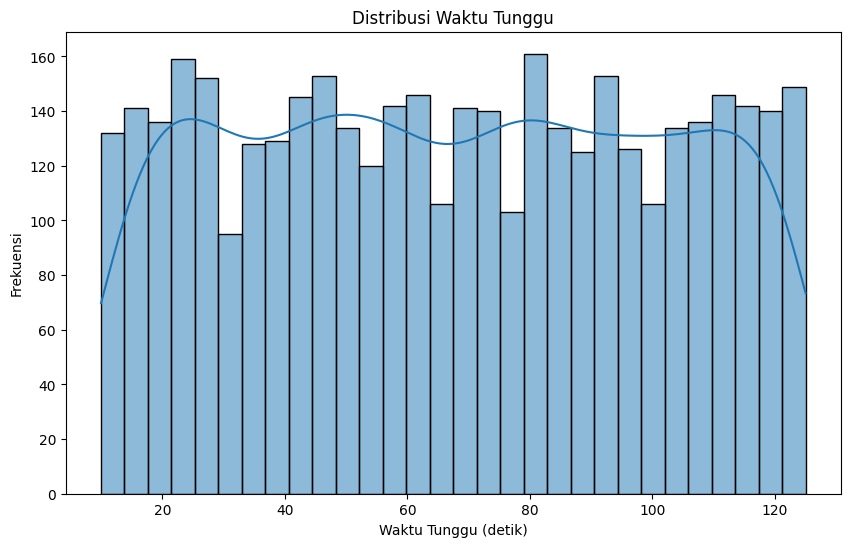

In [185]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Speed of answer in seconds'], bins=30, kde=True)
plt.title('Distribusi Waktu Tunggu')
plt.xlabel('Waktu Tunggu (detik)')
plt.ylabel('Frekuensi')
plt.show()

Distribusi durasi panggilan

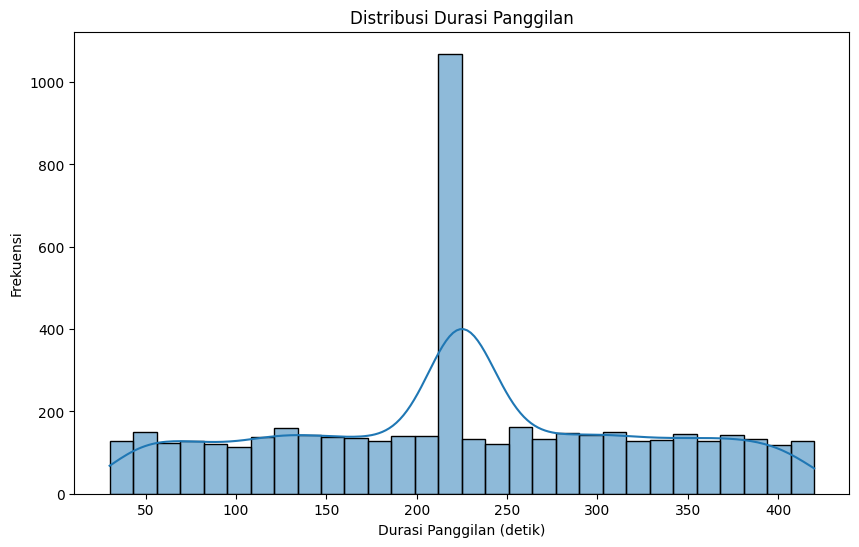

In [186]:
plt.figure(figsize=(10, 6))
sns.histplot(df['AvgTalkDuration_seconds'], bins=30, kde=True)
plt.title('Distribusi Durasi Panggilan')
plt.xlabel('Durasi Panggilan (detik)')
plt.ylabel('Frekuensi')
plt.show()

In [212]:
print(df['AvgTalkDuration_seconds'].describe())

count    5000.000000
mean      224.922792
std       100.290549
min        30.000000
25%       152.000000
50%       224.922792
75%       298.000000
max       420.000000
Name: AvgTalkDuration_seconds, dtype: float64


Pola kedatangan panggilan per jam

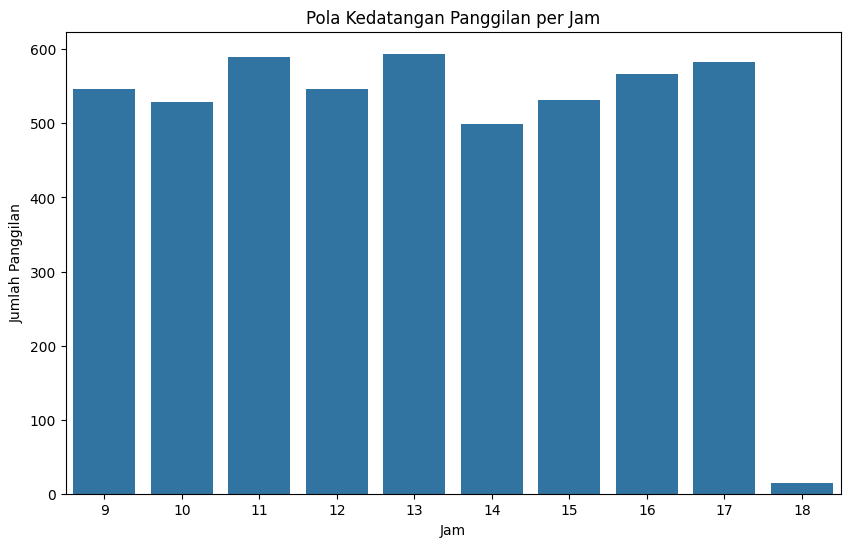

In [187]:
df['Hour'] = df['DateTime'].dt.hour
plt.figure(figsize=(10, 6))
sns.countplot(x='Hour', data=df)
plt.title('Pola Kedatangan Panggilan per Jam')
plt.xlabel('Jam')
plt.ylabel('Jumlah Panggilan')
plt.show()

# Langkah 3: Simulasi Antrian


Fungsi untuk mensimulasikan call center

In [188]:
def call_center(env, num_agents, call_data):
    agents = simpy.Resource(env, capacity=num_agents)
    total_service_time = 0  

    for index, row in call_data.iterrows():
        env.process(handle_call(env, row['Speed of answer in seconds'], row['AvgTalkDuration_seconds'], agents, total_service_time))
        yield env.timeout(random.expovariate(1.0 / 60))  

def handle_call(env, wait_time, talk_duration, agents, total_service_time):
    arrival_time = env.now
    print(f"Panggilan datang pada waktu {arrival_time}")

    with agents.request() as request:
        yield request
        start_service_time = env.now
        print(f"Panggilan mulai dilayani pada waktu {start_service_time}")

        yield env.timeout(talk_duration)
        end_service_time = env.now
        print(f"Panggilan selesai pada waktu {end_service_time}")

        total_service_time += talk_duration

Parameter simulasi

In [ ]:
num_agents = 7  # Jumlah agen
sim_time = 3600 # Waktu simulasi (1 jam)

# Langkah 4: Analisis Kinerja

Hitung metrik kinerja

In [209]:
average_wait_time = df['Speed of answer in seconds'].mean()
average_talk_duration = df['AvgTalkDuration_seconds'].mean()
total_service_time = df['AvgTalkDuration_seconds'].sum()
total_capacity = num_agents * sim_time

utilisasi dan pastikan dalam rentang 1-100%

In [210]:
utilization = (total_service_time / total_capacity) * 100
utilization = max(1, min(utilization, 100))

In [211]:
print(f"Rata-rata waktu tunggu: {average_wait_time} detik")
print(f"Rata-rata durasi panggilan: {average_talk_duration} detik")
print(f"Total waktu layanan: {total_service_time} detik")
print(f"Total kapasitas agen: {total_capacity} detik")
print(f"Utilisasi agen: {utilization:.2f}%")

Rata-rata waktu tunggu: 67.52072027627035 detik
Rata-rata durasi panggilan: 224.92279230389744 detik
Total waktu layanan: 1124613.9615194872 detik
Total kapasitas agen: 201600 detik
Utilisasi agen: 100.00%


# Langkah 5: Optimasi

Jalankan simulasi dengan jumlah agen yang berbeda

In [ ]:
for num_agents in [3, 5, 7]:
    env = simpy.Environment()
    env.process(call_center(env, num_agents, df))
    env.run(until=sim_time)
    
    total_service_time = df['AvgTalkDuration_seconds'].sum()
    total_capacity = num_agents * sim_time

    utilization = (total_service_time / total_capacity) * 100
    utilization = max(1, min(utilization, 100)) 

    print(f"Utilisasi dengan {num_agents} agen: {utilization:.2f}%")

Panggilan datang pada waktu 0
Panggilan mulai dilayani pada waktu 0
Panggilan datang pada waktu 32.96590750432975
Panggilan mulai dilayani pada waktu 32.96590750432975
Panggilan datang pada waktu 61.56051614772605
Panggilan mulai dilayani pada waktu 61.56051614772605
Panggilan datang pada waktu 89.59619481531647
Panggilan mulai dilayani pada waktu 89.59619481531647
Panggilan datang pada waktu 96.80661013130114
Panggilan mulai dilayani pada waktu 96.80661013130114
Panggilan selesai pada waktu 126.59619481531647
Panggilan selesai pada waktu 143.0
Panggilan selesai pada waktu 156.80661013130114
Panggilan selesai pada waktu 192.56051614772605
Panggilan datang pada waktu 244.0426148239339
Panggilan mulai dilayani pada waktu 244.0426148239339
Panggilan datang pada waktu 261.2847599902469
Panggilan mulai dilayani pada waktu 261.2847599902469
Panggilan selesai pada waktu 274.9659075043297
Panggilan datang pada waktu 307.76176525728505
Panggilan mulai dilayani pada waktu 307.76176525728505
Pang

# Langkah 6: Visualisasi Insight Tambahan

Korelasi antara waktu tunggu dan kepuasan

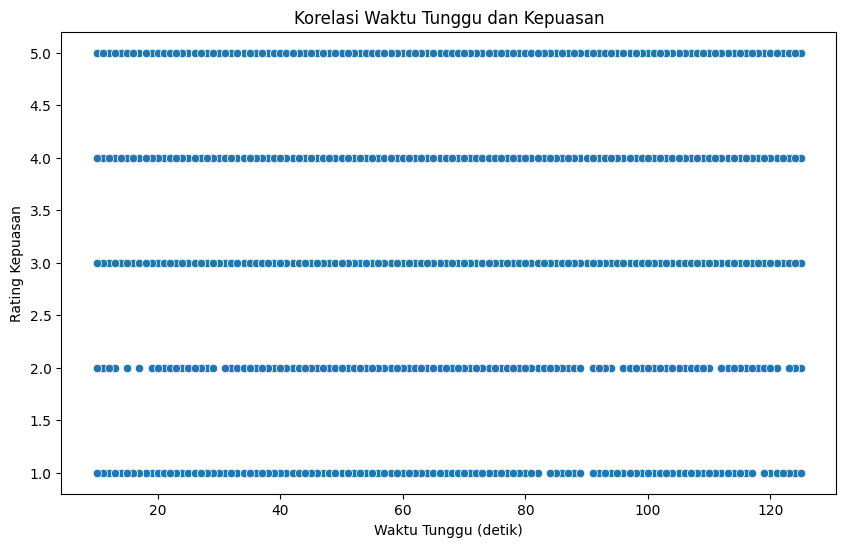

In [198]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Speed of answer in seconds', y='Satisfaction rating', data=df)
plt.title('Korelasi Waktu Tunggu dan Kepuasan')
plt.xlabel('Waktu Tunggu (detik)')
plt.ylabel('Rating Kepuasan')
plt.show()

Distribusi rating kepuasan

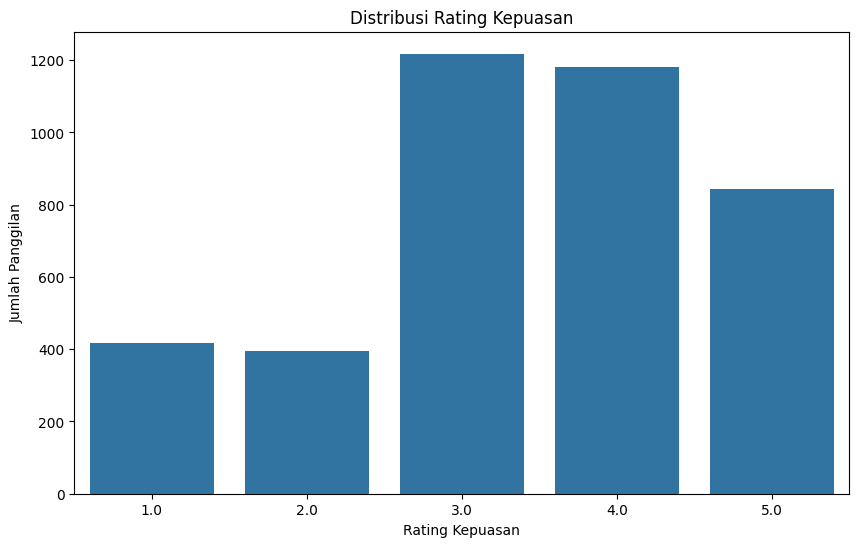

In [199]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Satisfaction rating', data=df)
plt.title('Distribusi Rating Kepuasan')
plt.xlabel('Rating Kepuasan')
plt.ylabel('Jumlah Panggilan')
plt.show()